In [1]:
import os
import json
import yaml
import pickle
import dill

import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

# Functions

In [2]:
def process_solution(solution_values: list):
    """Replace the values by whether the solution is green, red or from another colour
            - drink mix: red
            - cobalt (ii) nitrate: red 
            - cobalt (ii) chloride: other [orange]
            - potassium dichromate: other [orange]
            - potassium chromate: other [yellow]
            - nickel (ii) chloride: green
            - copper (ii) sulfate: other [blue]
            - potassium permanganate: other [purple]
    Args:
        solution_values (list): [replaced all solutions by red, green or other]
    """        
    colour_map = {
        'drinkMix': 'red',
        'potassiumDichromate': 'other',
        'cobaltChloride': 'other',
        'copperSulfate': 'other',
        'nickelIIChloride': 'green',
        'potassiumPermanganate': 'other',
        'potassiumChromate': 'other',
        'cobaltIINitrate': 'red'
    }
    solution_values = [s.replace('beersLawLab.beersLawScreen.solutions.', '') for s in solution_values]
    solution_values = [colour_map[s] for s in solution_values]
    return solution_values

In [3]:
def get_solution_distribution(values:list, timestamps: list, last_ts: float) -> dict:
    vs = [values[0]]
    ts = [timestamps[0]]
    
    for i in range(len(values[1:])):
        if vs[-1] == values[i]:
            continue
        else:
            vs.append(values[i])
            ts.append(timestamps[i])
    begin = ts
    ends = ts[1:] + [last_ts]
    
    distribution = {
        'red': 0,
        'green': 0,
        'other': 0
    }
    
    for i, val in enumerate(vs):
        distribution[val] += ends[i] - begin[i]
    return distribution
    
    

# Data

In [4]:
with open('../data/experiment_keys/permutation_maps/colour_binary.yaml') as fp:
    col_bin = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('../data/experiment_keys/permutation_maps/concentration_binary.yaml') as fp:
    con_bin = yaml.load(fp, Loader=yaml.FullLoader)
    
with open('../data/experiment_keys/permutation_maps/width_binary.yaml') as fp:
    wid_bin = yaml.load(fp, Loader=yaml.FullLoader)

In [5]:
with open('//ic1files.epfl.ch/D-VET/Projects/ChemLab/04_Processing/Processing/Data/PostTest/post_test.pkl', 'rb') as fp:
    post_test = pickle.load(fp)
    ranks = pd.DataFrame()
    ranks['lid'] = post_test[0, 'username']
    ranks['gender'] = post_test[0, 'gender']
    ranks['year'] = post_test[0, 'year']
    ranks['ranks'] = post_test[6, 'ranks']

    ranks = ranks[ranks['ranks'].notna()]
    ranks['permutation'] = ranks['ranks'].apply(lambda x: ''.join([str(r) for r in x]))
    ranks = ranks.set_index('lid')

In [6]:
# all parsed files
parsed_path = '../data/parsed simulations/'
parsed = os.listdir(parsed_path)

# get distributions
distribution = {}
for file in parsed:
    with open(parsed_path + file, 'rb') as fp:
        p = dill.load(fp)
        solution = p.get_solution()
        values = process_solution(solution[0])
        dist = get_solution_distribution(values, solution[1], p.get_last_timestamp())
        distribution[p.get_learner_id()] = dist
        try:
            distribution[p.get_learner_id()]['permutation'] = ranks.loc[p.get_learner_id()]['permutation']
        except KeyError:
            distribution['permutation'] = ''
           
        
distribution_df = pd.DataFrame(distribution).transpose()
distribution_df = distribution_df[~distribution_df['permutation'].isna()]
distribution_df = distribution_df[distribution_df['permutation'] != '']
def get_colbin_labels(x:str, colbin:dict) -> str:
    return colbin['map'][x]

def get_conbin_labels(x:str, conbin:dict) -> str:
    return conbin['map'][x]

def get_widbin_labels(x:str, widbin:dict) -> str:
    lab = widbin['map'][x]
    if lab == 'no_width':
        return 'width_no'
    else:
        return lab
distribution_df['colbin'] = distribution_df['permutation'].apply(lambda x: get_colbin_labels(x, col_bin))
distribution_df['conbin'] = distribution_df['permutation'].apply(lambda x: get_conbin_labels(x, con_bin))
distribution_df['widbin'] = distribution_df['permutation'].apply(lambda x: get_widbin_labels(x, wid_bin))

# Plots

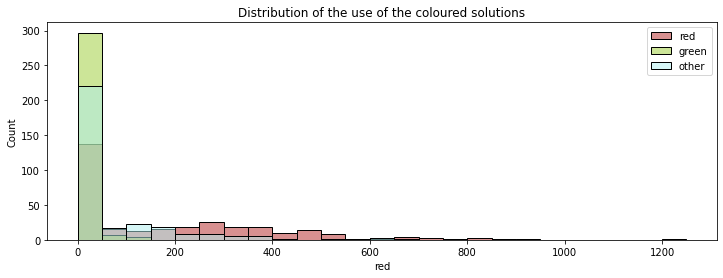

In [8]:
binwidth = 50
plt.figure(figsize=(12, 4))
plt.title('Distribution of the use of the coloured solutions')
sns.histplot(distribution_df['red'], binwidth=binwidth, label='red', color='firebrick', alpha=0.5)
sns.histplot(distribution_df['green'], binwidth=binwidth, label='green', color='yellowgreen', alpha=0.5)
sns.histplot(distribution_df['other'], binwidth=binwidth, label='other', color='paleturquoise', alpha=0.5)
plt.legend()
plt.show()

## Colour

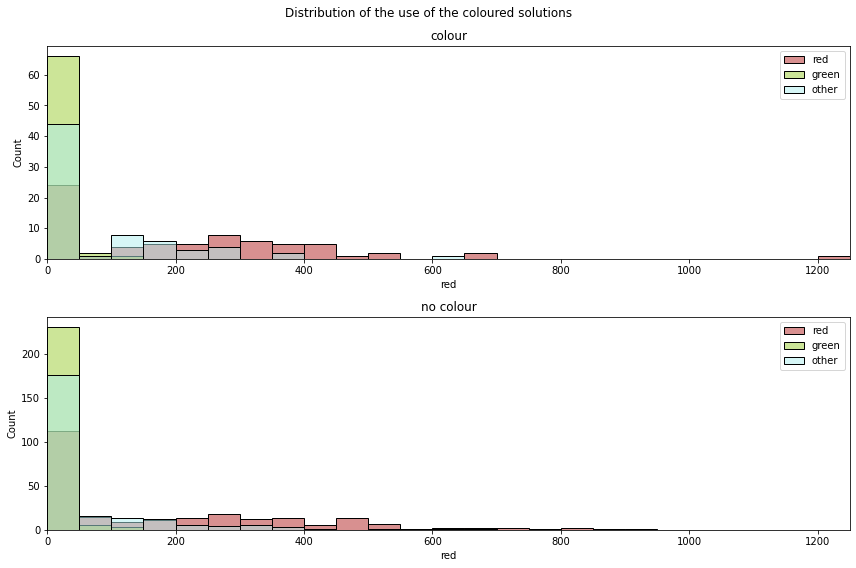

In [19]:
col_df = distribution_df[distribution_df['colbin'] == 'colour']
nocol_df = distribution_df[distribution_df['colbin'] == 'no_col']

plt.figure(figsize=(12, 8))
plt.suptitle('Distribution of the use of the coloured solutions')

plt.subplot(2, 1, 1)
plt.title('colour')
sns.histplot(col_df['red'], binwidth=binwidth, label='red', color='firebrick', alpha=0.5)
sns.histplot(col_df['green'], binwidth=binwidth, label='green', color='yellowgreen', alpha=0.5)
sns.histplot(col_df['other'], binwidth=binwidth, label='other', color='paleturquoise', alpha=0.5)
plt.legend()
plt.xlim([0, 1250])

plt.subplot(2, 1, 2)
plt.title('no colour')
sns.histplot(nocol_df['red'], binwidth=binwidth, label='red', color='firebrick', alpha=0.5)
sns.histplot(nocol_df['green'], binwidth=binwidth, label='green', color='yellowgreen', alpha=0.5)
sns.histplot(nocol_df['other'], binwidth=binwidth, label='other', color='paleturquoise', alpha=0.5)
plt.xlim([0, 1250])
plt.legend()

plt.tight_layout()
plt.show()


## width

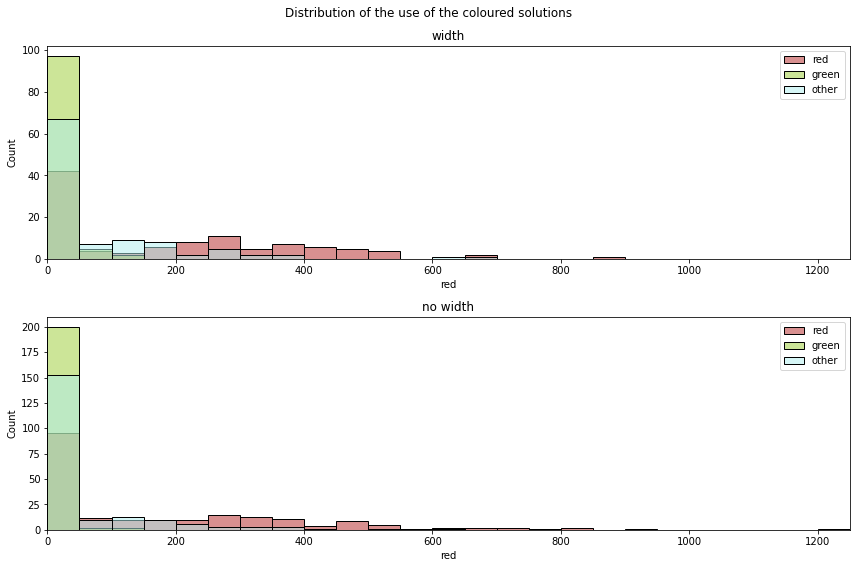

In [18]:
w_df = distribution_df[distribution_df['widbin'] == 'width']
now_df = distribution_df[distribution_df['widbin'] == 'width_no']

plt.figure(figsize=(12, 8))
plt.suptitle('Distribution of the use of the coloured solutions')

plt.subplot(2, 1, 1)
plt.title('width')
sns.histplot(w_df['red'], binwidth=binwidth, label='red', color='firebrick', alpha=0.5)
sns.histplot(w_df['green'], binwidth=binwidth, label='green', color='yellowgreen', alpha=0.5)
sns.histplot(w_df['other'], binwidth=binwidth, label='other', color='paleturquoise', alpha=0.5)
plt.legend()
plt.xlim([0, 1250])

plt.subplot(2, 1, 2)
plt.title('no width')
sns.histplot(now_df['red'], binwidth=binwidth, label='red', color='firebrick', alpha=0.5)
sns.histplot(now_df['green'], binwidth=binwidth, label='green', color='yellowgreen', alpha=0.5)
sns.histplot(now_df['other'], binwidth=binwidth, label='other', color='paleturquoise', alpha=0.5)
plt.xlim([0, 1250])
plt.legend()

plt.tight_layout()
plt.show()

## concentration

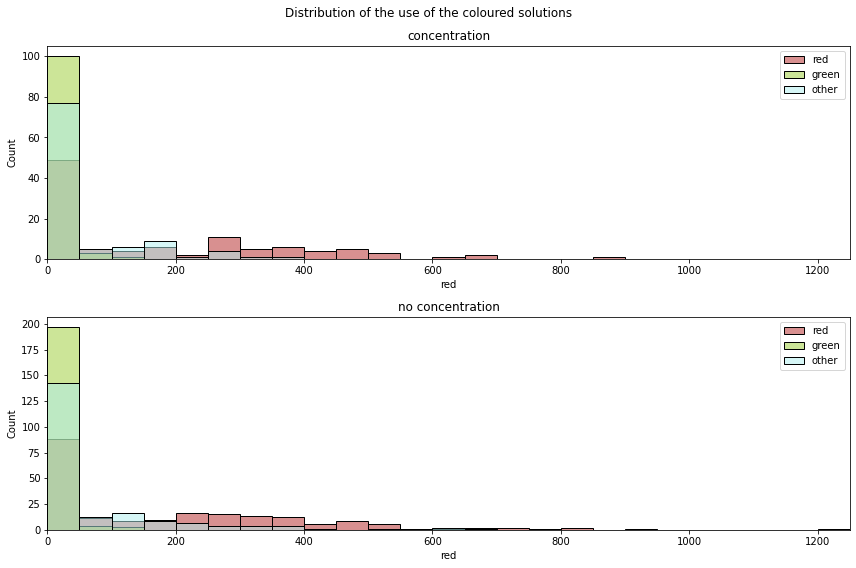

In [20]:
conc_df = distribution_df[distribution_df['conbin'] == 'concentration']
noconc_df = distribution_df[distribution_df['conbin'] == 'no_conc']

plt.figure(figsize=(12, 8))
plt.suptitle('Distribution of the use of the coloured solutions')

plt.subplot(2, 1, 1)
plt.title('concentration')
sns.histplot(conc_df['red'], binwidth=binwidth, label='red', color='firebrick', alpha=0.5)
sns.histplot(conc_df['green'], binwidth=binwidth, label='green', color='yellowgreen', alpha=0.5)
sns.histplot(conc_df['other'], binwidth=binwidth, label='other', color='paleturquoise', alpha=0.5)
plt.legend()
plt.xlim([0, 1250])

plt.subplot(2, 1, 2)
plt.title('no concentration')
sns.histplot(noconc_df['red'], binwidth=binwidth, label='red', color='firebrick', alpha=0.5)
sns.histplot(noconc_df['green'], binwidth=binwidth, label='green', color='yellowgreen', alpha=0.5)
sns.histplot(noconc_df['other'], binwidth=binwidth, label='other', color='paleturquoise', alpha=0.5)
plt.xlim([0, 1250])
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
p.get_metric()

(['transmittance', 'transmittance'], [0, 659.205])

In [23]:
p.get_last_timestamp()

659.205

In [ ]:
a